# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase is given. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

We also need to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, we wouldn't want to send a buy 10 dollars get 2 dollars off offer. We'll want to try to assess what a certain demographic group will buy when not receiving any offers.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Data Cleaning 

## Datasets Loading

In [1]:
#import all neccessary libraries

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

#libraries for ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from time import time

# read in the json files
df1 = pd.read_json('data/portfolio.json', orient='records', lines=True)
df2 = pd.read_json('data/profile.json', orient='records', lines=True)
df3 = pd.read_json('data/transcript.json', orient='records', lines=True)

## Datasets Cleaning

### Portfolio
There is no missing values or duplicates in this file. 
* rename column id to offer id
* change id to numerical offer id
* create a dummy column for offer_type (informational,discount,bogo)
* create dummy columns for channels

In [2]:
portfolio = df1.copy()
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
#rename column id to offer_id
portfolio = portfolio.rename(columns={"id":"offer_id"})

In [4]:
#encode offer ids in portfolio dataframe from string format to integer
offer_ids = portfolio['offer_id'].unique()
offer_ids_dict = pd.Series(offer_ids).to_dict()
offer_ids_dict = dict([(value,key) for key,value in offer_ids_dict.items()])

In [5]:
offer_ids_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [6]:
#map offer id in portfolio to the encoded offer id
portfolio['offer_id'] = portfolio['offer_id'].map(offer_ids_dict)

In [7]:
#get the dummy columns for the offer_type
dummy_offertype = pd.get_dummies(portfolio.offer_type, prefix=None, dtype=int)

#merge the dummy columns with the portfolio df
portfolio = pd.concat([portfolio,dummy_offertype],axis=1)

#drop the offer_type column
# portfolio.drop(['offer_type'],axis =1, inplace= True)

In [8]:
#get dummies for column 'channels'
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum()

#merge the dummy with the portfolio df
portfolio = pd.concat([portfolio,dummy],axis=1)

#drop the channels column
portfolio.drop(['channels'],axis =1, inplace= True)

In [9]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,bogo,0,1,0,0,1,1,1,0
1,10,10,5,bogo,1,1,0,0,1,1,1,1
2,0,0,4,informational,2,0,0,1,1,1,0,1
3,5,5,7,bogo,3,1,0,0,1,1,0,1
4,5,20,10,discount,4,0,1,0,1,0,0,1


### Profile

In [10]:
profile = df2.copy()
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.shape

(17000, 5)

In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
profile[profile.age == 118].sort_values('income', ascending = False)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [15]:
#checking if it has any value for gender and income
profile[profile.age == 118].gender.notna().sum() , profile[profile.age == 118].income.notna().sum()


(0, 0)

There is a high count for the outliers age (age = 118) which is more than 2k. This could be when customer didn't enter their age in the form, it will automatically set to a default date. 

We have to take care of missing values if we want to do modelling later. There are three options that we have; get rid of the corresponding districts, get rid of the whole attributes or replace the values to some value. So, in this case we are going to remove this data because it's representing false age and even the income and gender data are missing.

In [16]:
profile = profile[profile['age']<118].reset_index(drop=True)

In [17]:
profile.age.sort_values()

3469      18
5910      18
5151      18
1964      18
645       18
        ... 
13787    101
3548     101
12969    101
14707    101
1340     101
Name: age, Length: 14825, dtype: int64

In [18]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [19]:
profile.duplicated().sum()

0

From the information above, we see that there is no missing value or duplicated rows.

So the next cleaning process for this dataset will be:

- change id to customer_id
- change customer_id to encoded id
- change datatype for column became_member_on to date

In [20]:
#rename id to customer_id
profile = profile.rename(columns = {'id':'customer_id'})

customer_ids = pd.unique(profile['customer_id'])

#encode customer ids which is in string format to integers
customer_ids_dict = pd.Series(customer_ids).to_dict()

#swap value and key
customer_ids_dict = dict([(value, key) for key, value in customer_ids_dict.items()]) 

#map the new encoded customer id to the old customer id in profile table
profile['customer_id'] = profile['customer_id'].map(customer_ids_dict)

In [21]:
#change datatype column 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

In [22]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,F,55,0,2017-07-15,112000.0
1,F,75,1,2017-05-09,100000.0
2,M,68,2,2018-04-26,70000.0
3,M,65,3,2018-02-09,53000.0
4,M,58,4,2017-11-11,51000.0


In [23]:
profile.dtypes

gender                      object
age                          int64
customer_id                  int64
became_member_on    datetime64[ns]
income                     float64
dtype: object

### Transcript

In [24]:
transcript = df3.copy()
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [28]:
transcript.event.value_counts() 

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

Data cleaning to do:

- change column name from 'person' to 'customer_id'
- convert the column 'Event' into 4 different columns based on their value (offer received/offer viewed/offer completed/transaction)
- convert the column 'Values' into columns according to the value's dictionary keys
- map encoded customer ids to ids in transcript and profile dataframes


In [29]:
#change person to 'customer_id'
transcript = transcript.rename(columns={'person':'customer_id'})

In [30]:
#replace space with underscore for values in event column
transcript['event'] = transcript.event.str.replace(' ','_')

In [31]:
#Convert categorical variable into dummy variables.
dummy = pd.get_dummies(transcript.event,dtype=int)

# merge back all the dummy variables
transcript = pd.concat([transcript,dummy], axis=1)

#drop the event column 
transcript = transcript.drop('event',axis= 1)

In [32]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   customer_id      306534 non-null  object
 1   value            306534 non-null  object
 2   time             306534 non-null  int64 
 3   offer_completed  306534 non-null  int64 
 4   offer_received   306534 non-null  int64 
 5   offer_viewed     306534 non-null  int64 
 6   transaction      306534 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 16.4+ MB


In [33]:
dummy_val = transcript['value'].apply(pd.Series)

In [34]:
dummy_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


Rename the 'offer id' to 'offer_id' and combine with the existing 'offer_id'. We can drop the reward column as it is already captured in portfolio dataframe.

In [35]:
dummy_val.offer_id.fillna(dummy_val['offer id'],inplace = True)

/var/folders/3t/k2d3c7k50ybfm83nhrzl90gh0000gn/T/ipykernel_3075/3872812856.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dummy_val.offer_id.fillna(dummy_val['offer id'],inplace = True)


In [36]:
dummy_val = dummy_val.drop(['offer id','reward'],axis = 1)

In [37]:
dummy_val.head()

,amount,offer_id
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,NaN,2906b810c7d4411798c6938adc9daaa5
3,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [38]:
#combined the dummy_val to the transcript df
transcript = pd.concat([transcript,dummy_val], axis = 1)

#drop the value column
transcript = transcript.drop('value', axis = 1)

In [39]:
#map encoded customer ids to ids in transcrpt dataframes
transcript['customer_id'] = transcript['customer_id'].map(customer_ids_dict)

In [40]:
#map offer id in transcript to the encoded offer id
transcript['offer_id'] = transcript['offer_id'].map(offer_ids_dict)

In [41]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      272762 non-null  float64
 1   time             306534 non-null  int64  
 2   offer_completed  306534 non-null  int64  
 3   offer_received   306534 non-null  int64  
 4   offer_viewed     306534 non-null  int64  
 5   transaction      306534 non-null  int64  
 6   amount           138953 non-null  float64
 7   offer_id         167581 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 18.7 MB


In [42]:
#drop all rows contain NA because they are the customer with age~118 that we removed earlier in profile table

transcript.dropna(axis = 0, subset = ['customer_id'], inplace = True, ignore_index=True)

In [43]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272762 entries, 0 to 272761
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      272762 non-null  float64
 1   time             272762 non-null  int64  
 2   offer_completed  272762 non-null  int64  
 3   offer_received   272762 non-null  int64  
 4   offer_viewed     272762 non-null  int64  
 5   transaction      272762 non-null  int64  
 6   amount           123957 non-null  float64
 7   offer_id         148805 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 16.6 MB


In [44]:
transcript.head()

,customer_id,time,offer_completed,offer_received,offer_viewed,transaction,amount,offer_id
0,1.0,0,0,1,0,0,NaN,3.0
1,2.0,0,0,1,0,0,NaN,9.0
2,3.0,0,0,1,0,0,NaN,8.0
3,4.0,0,0,1,0,0,NaN,2.0
4,5.0,0,0,1,0,0,NaN,4.0


### Combining Dataset

In [45]:
df = pd.merge(profile,transcript, how = 'outer', on = 'customer_id')
df = pd.merge(df,portfolio, how = 'outer', on = 'offer_id')
df.head()

,gender,age,customer_id,became_member_on,income,time,offer_completed,offer_received,offer_viewed,transaction,...,difficulty,duration,offer_type,bogo,discount,informational,email,mobile,social,web
0,F,75,1,2017-05-09,100000.0,408,0,1,0,0,...,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,F,75,1,2017-05-09,100000.0,408,0,0,1,0,...,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0
2,F,75,1,2017-05-09,100000.0,510,1,0,0,0,...,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0
3,F,61,5,2017-09-11,57000.0,408,0,1,0,0,...,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,F,61,5,2017-09-11,57000.0,426,1,0,0,0,...,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0


# Data Visualisation

## Offers

In the first part, let's explore the offer types. Let find out the business funnel for the offers and what criteria does the offer has for the higher conversion. 

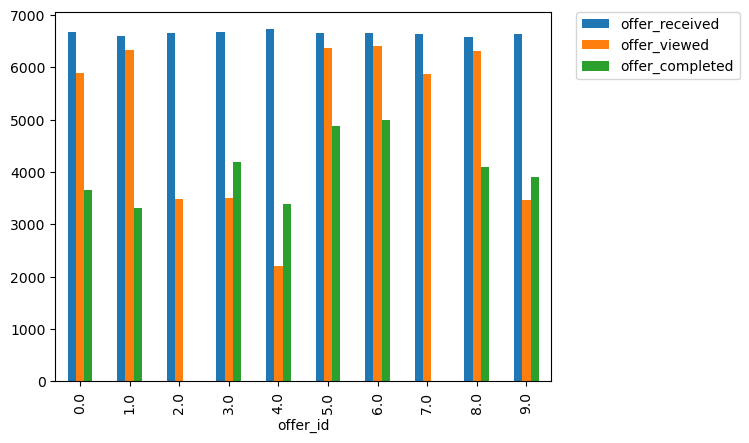

In [46]:
df.groupby(['offer_id'])[['offer_received','offer_viewed','offer_completed']].sum().plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.);

It's hard to deduce from the chart above but we can see some of the have 0 completion. Let's plot them base of the offer type instead of offer individually.

In [47]:
offer_type_funnel = df.groupby('offer_type')[['offer_received','offer_viewed','offer_completed']].sum()
offer_type_funnel

,offer_received,offer_viewed,offer_completed
offer_type,,,
bogo,26537,22039,15258
discount,26664,18461,17186
informational,13300,9360,0


Since this is the sum value for all the offers base on the offer type, we are going to average them base on the offer_type count and plot the number in a bar graph.

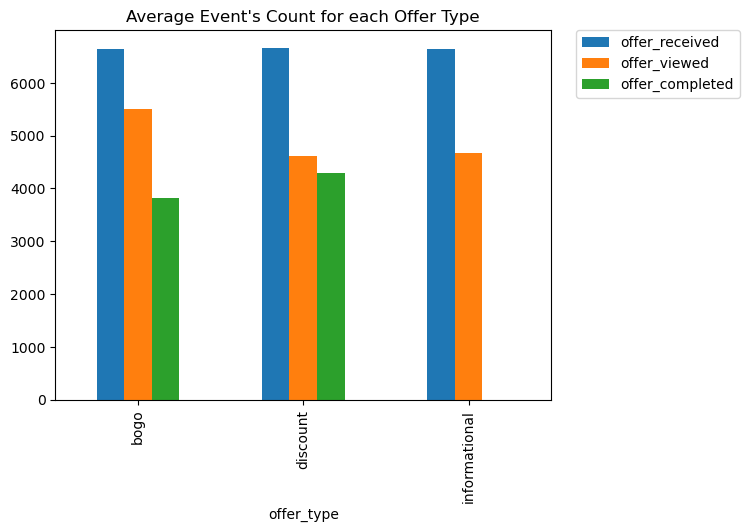

In [48]:
#divider is the counts of each offer type
divider = portfolio.offer_type.value_counts().values

#average received,viewed,and completed value for each offer base on their type
(offer_type_funnel.T/divider).T.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.title("Average Event's Count for each Offer Type");

To make a fair comparison, let's normalize the above value and replot them.

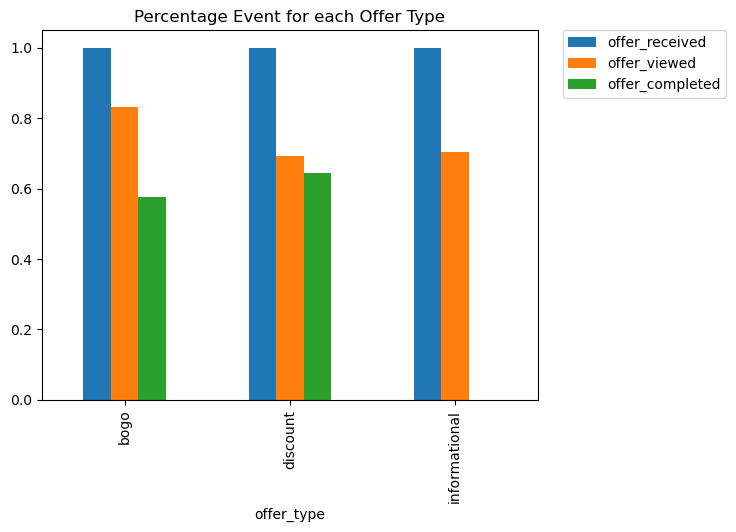

In [49]:
# ab = pd.merge(a,b, on = 'offer_type')
# pd.merge(ab,c, on = 'offer_type').plot.bar()
offer_type = (offer_type_funnel.T/divider)/(offer_type_funnel.T/divider).iloc[0]
offer_type.T.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.title("Percentage Event for each Offer Type");

From the chart above, we can see that customer seems to be most interested in BOGO offer, hence it has the highest view but it doesn't mean that it has the highest conversion. The discout type offer seems to have the highest conversion which means most of them that viewed the offer has high chance of completing the offer. Meanwhile, the informational offer seems to have no conversion at all, maybe because customer realized they are not gaining anything here.

How about the difficulty of the offer? Does it show any trend on completed offer counts? Let's explore that below.

In [50]:
offer_type_funnel = df.groupby('difficulty')[['offer_received','offer_viewed','offer_completed']].sum()
offer_type_funnel

,offer_received,offer_viewed,offer_completed
difficulty,,,
0.0,13300,9360,0
5.0,13261,9809,8291
7.0,6655,6379,4886
10.0,26559,22097,15881
20.0,6726,2215,3386


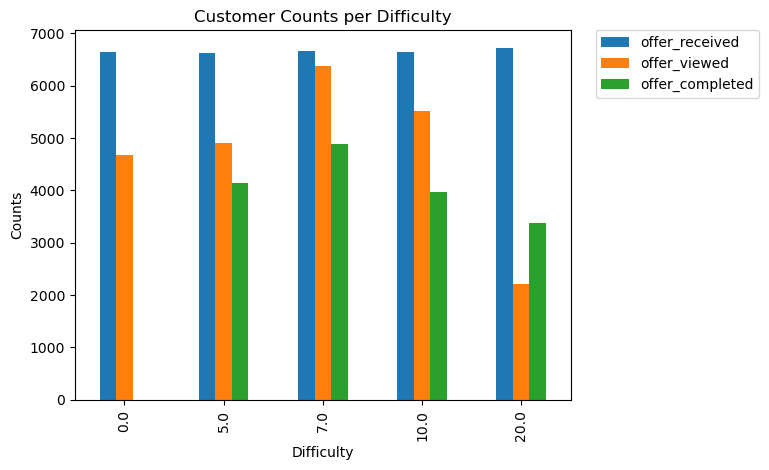

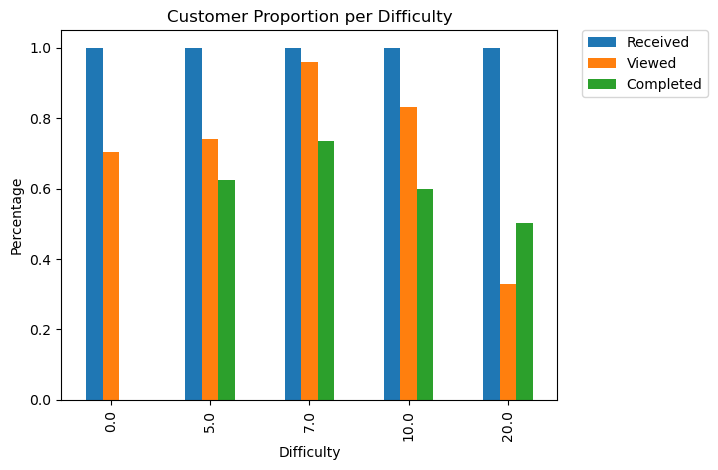

In [51]:
#divider is the counts of each offer type
divider = portfolio.difficulty.value_counts().sort_index().values
#average received,viewed,and completed value for each offer base on their difficulty
(offer_type_funnel.T/divider).T.plot.bar();
plt.title("Customer Counts per Difficulty")
plt.ylabel('Counts')
plt.xlabel('Difficulty')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)

a = pd.Series((offer_type_funnel.T/divider).iloc[0]/(offer_type_funnel.T/divider).iloc[0], name = 'Received')
b = pd.Series((offer_type_funnel.T/divider).iloc[1]/(offer_type_funnel.T/divider).iloc[0], name = 'Viewed')
c = pd.Series((offer_type_funnel.T/divider).iloc[2]/(offer_type_funnel.T/divider).iloc[0], name = 'Completed')

ab = pd.merge(a,b, on = 'difficulty')
pd.merge(ab,c, on = 'difficulty').plot.bar()
plt.title("Customer Proportion per Difficulty")
plt.ylabel('Percentage')
plt.xlabel('Difficulty')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.);

In [52]:
portfolio.groupby(['offer_type','difficulty']).offer_id.count()

offer_type     difficulty
bogo           5             2
               10            2
discount       7             1
               10            2
               20            1
informational  0             2
Name: offer_id, dtype: int64

Informational offer is the only offer that has 0 difficulty. Most people viewed the  difficulty between 5-10 with 7 having the highest count for both views and completions as well.
The completed offer for difficulty level 20, has more percentage of completions compared to the total viewed. This could obviously resulted by the inclusion of the demographic who doesn't even view the offer but still make the purchase anyway (which was explain earlier in the introduction).

The informational offer could be intentionnally to blast information to customers only and for example if there is a new released product or seasonal drinks. In reality there must have been people buying the new drinks. So in this case the 0 doesn't make sense unless if we can track the distribution of the offer related to which product and find the sales value of that particular product right after the offer distribution date. However, all this informations are not available here in the dataset.

## Distributions of Customer's Age,Gender and Income


Now, let's explore the customer's data. Let's find out about the age, gender and are there any correlation between the customer and the offer.

In [53]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,F,55,0,2017-07-15,112000.0
1,F,75,1,2017-05-09,100000.0
2,M,68,2,2018-04-26,70000.0
3,M,65,3,2018-02-09,53000.0
4,M,58,4,2017-11-11,51000.0


Let's look at the age distribution after we have remove the maximum age of 118 in the earlier cleaning part.

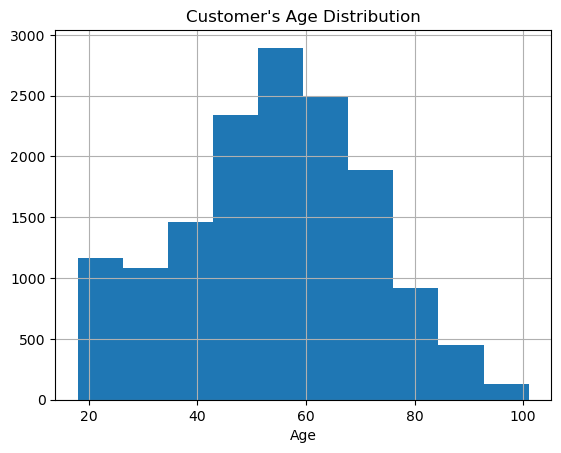

In [54]:
# profile = profile[profile.age < profile.age.max()]
plt.hist(profile.age)
plt.grid()
plt.title("Customer's Age Distribution")
plt.xlabel("Age");

They are normally distributed with median around 55 of age and slightly skewed to the right.

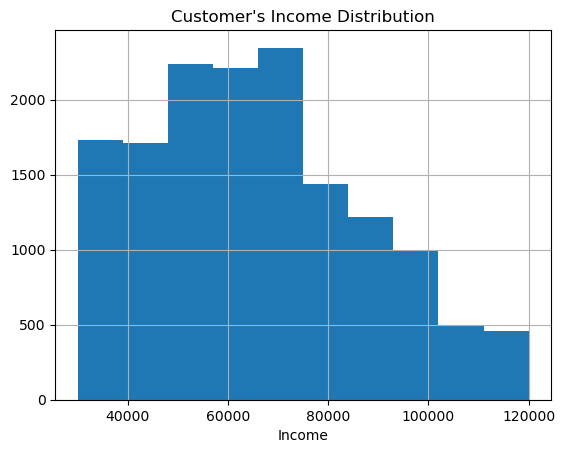

In [55]:
plt.hist(profile.income)
plt.grid()
plt.title("Customer's Income Distribution")
plt.xlabel("Income");

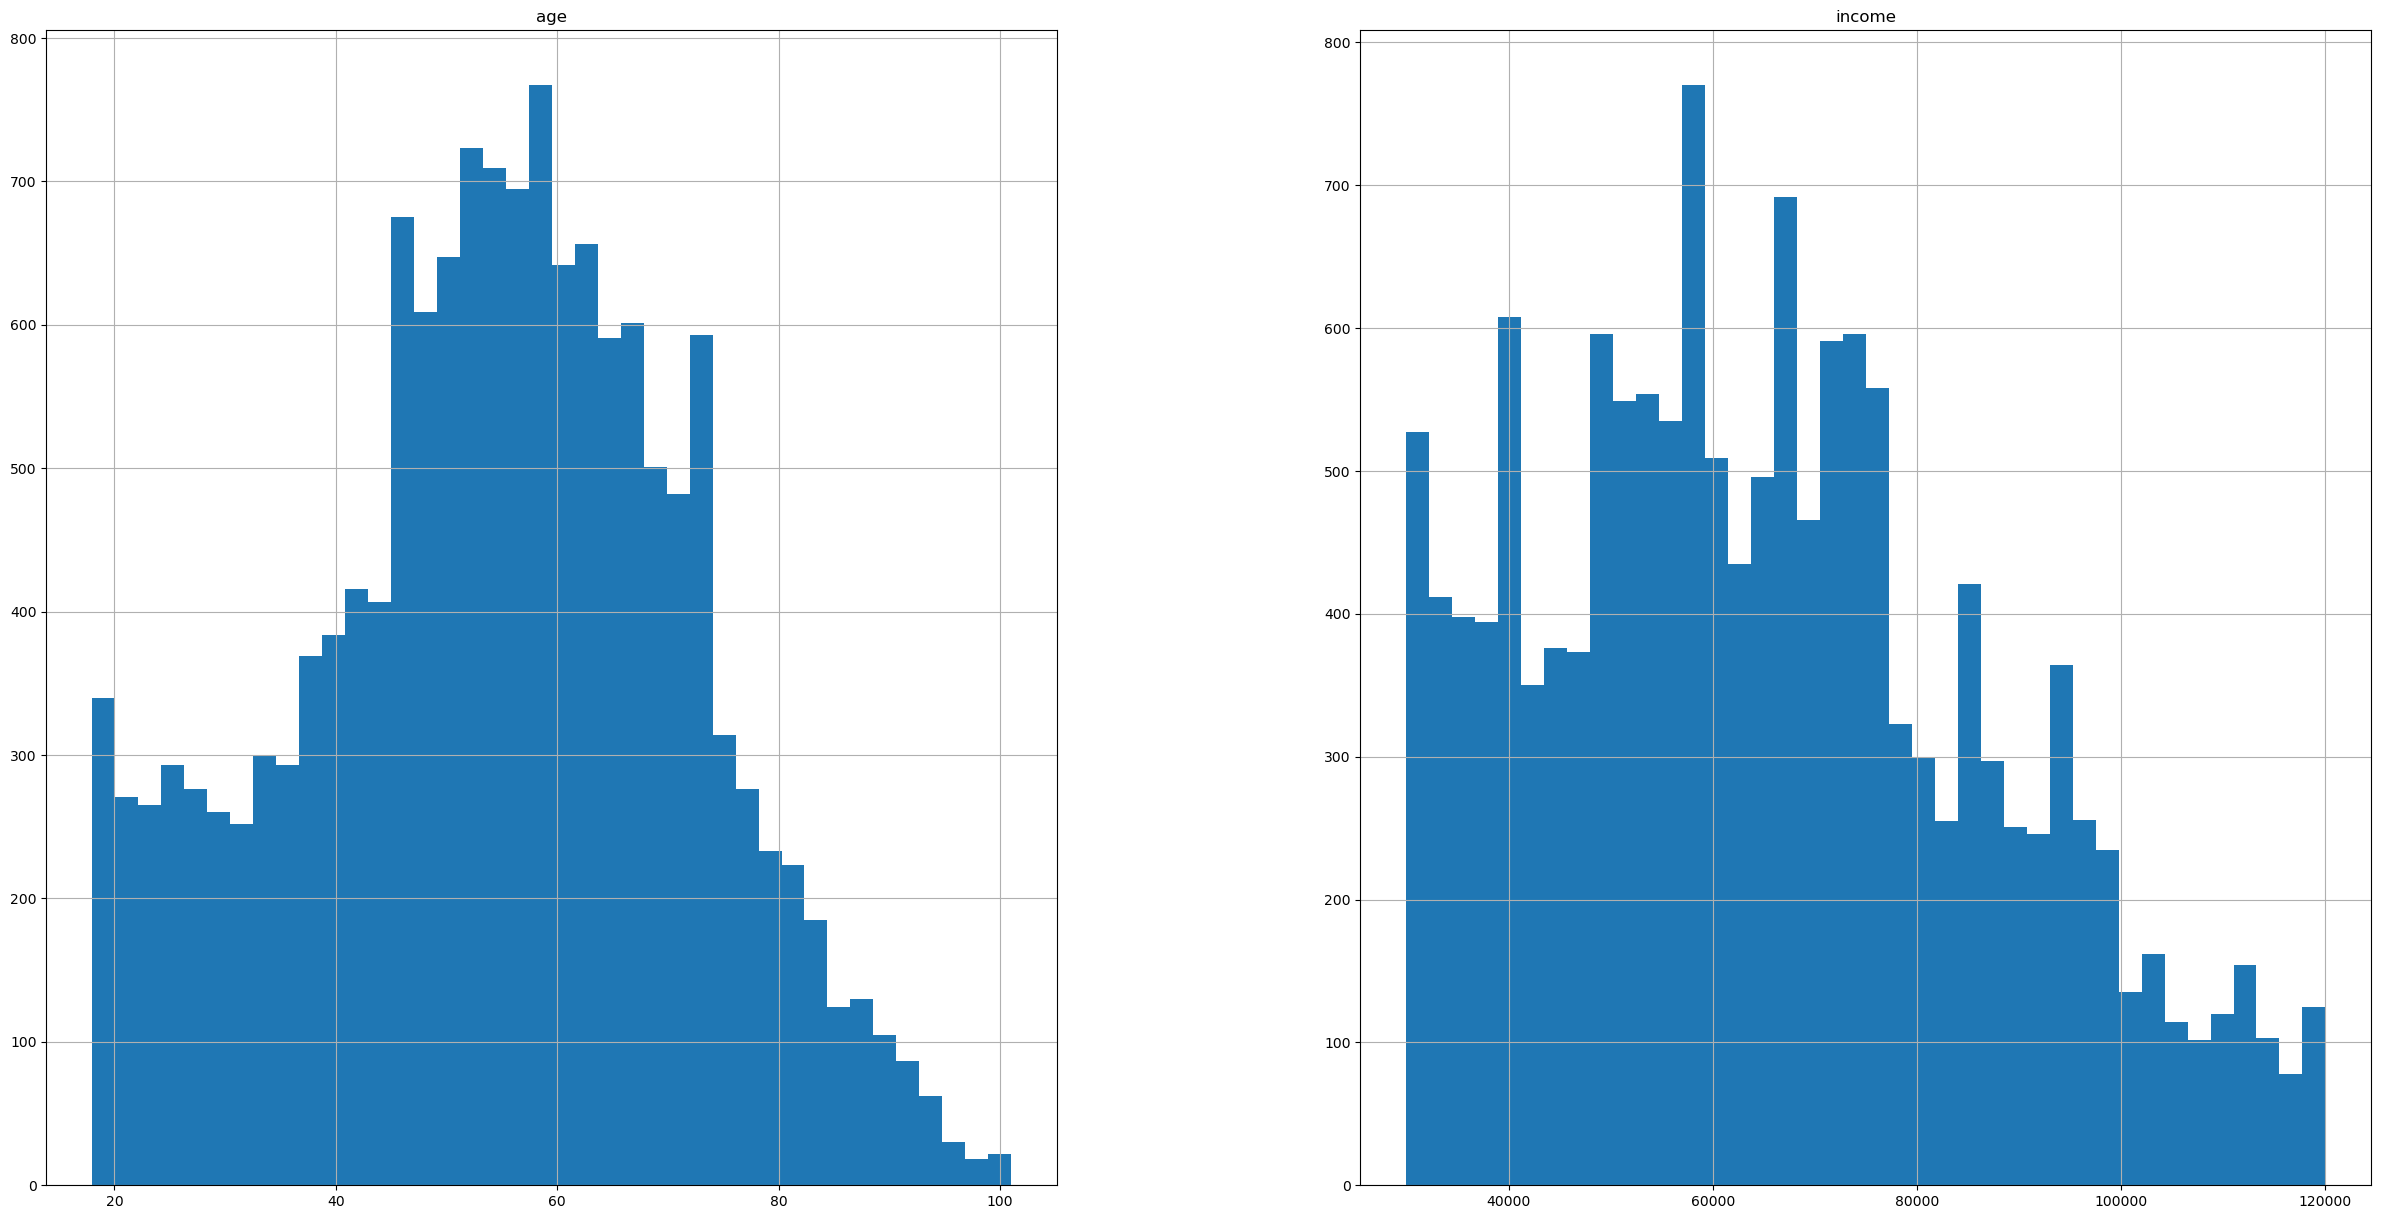

In [56]:
profile[['age','income']].hist(bins =40,figsize =(30,15))
plt.show;

In [57]:
#cust age and income distribution

profile.describe()

,age,customer_id,became_member_on,income
count,14825.000000,14825.000000,14825,14825.000000
mean,54.393524,7412.000000,2017-02-18 12:30:15.419898880,65404.991568
min,18.000000,0.000000,2013-07-29 00:00:00,30000.000000
25%,42.000000,3706.000000,2016-05-20 00:00:00,49000.000000
50%,55.000000,7412.000000,2017-08-02 00:00:00,64000.000000
75%,66.000000,11118.000000,2017-12-30 00:00:00,80000.000000
max,101.000000,14824.000000,2018-07-26 00:00:00,120000.000000
std,17.383705,4279.753206,NaN,21598.299410


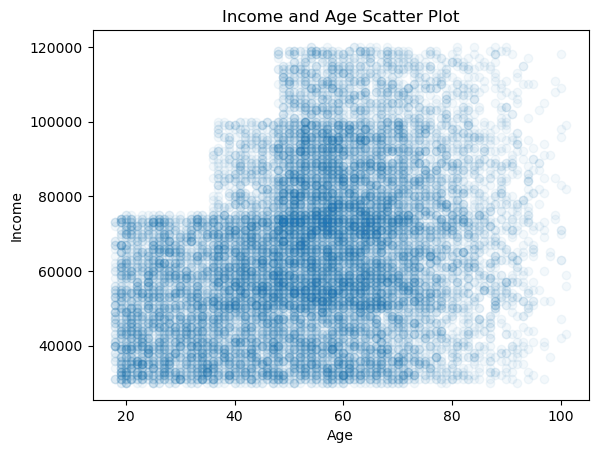

In [58]:
#scatter plot to see relationship between age and income
plt.scatter(profile.age, profile.income, alpha = 0.05)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Income and Age Scatter Plot');

The above plot some how show the data are being capped multiple times for both age and income.
The income is capped at around 75k in the first level, then at 100k and 120k for the subsequent levels. Same goes to the age where we can see the age start at 18 years old, then there is another minimum cap that start around mid 30s and another one around 50 years old. 

In [59]:
#just checking if the data is actually capped based on the time they became a member

profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  int64         
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 579.2+ KB


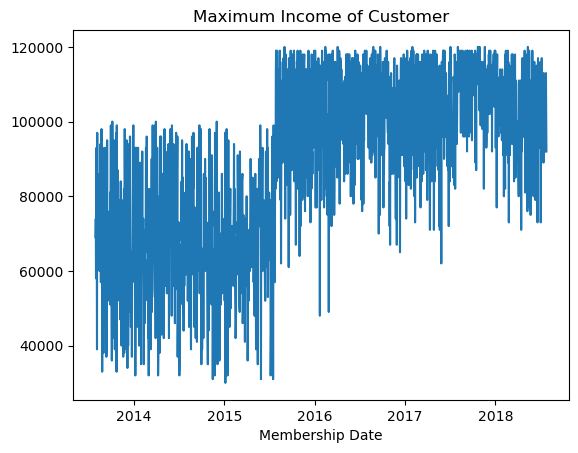

In [60]:
plt.plot(profile.groupby('became_member_on')[['income']].max())
plt.xlabel("Membership Date")
plt.title("Maximum Income of Customer");

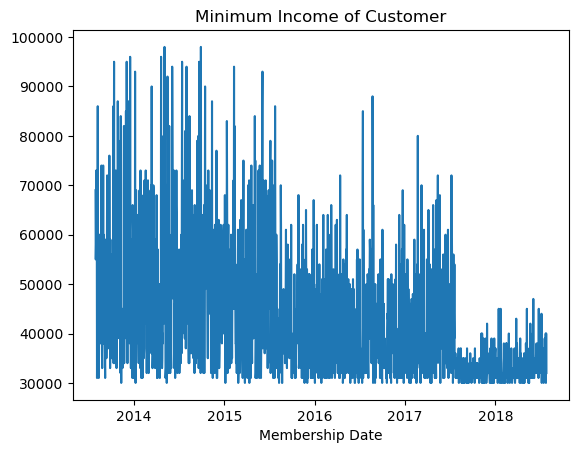

In [61]:
plt.plot(profile.groupby('became_member_on')[['income']].min())
plt.xlabel("Membership Date")
plt.title("Minimum Income of Customer");

It's interesting how the maximum income for who became Starbuck's member before midyear 2015 was at 100k and right after that period, the value was at 120k. 

Meanwhile the minimum income is showing an obvious different trend before and after mid 2017 and a slight different trend from the beginneing of the date until mid 2015. This somehow conclude that there are three different timeframe data, mid 2013 to mid 2015, mid 2015 to mid 2017 and lastly after mid 2017. This could be the reason behind the capped data in the scatter plot on the income and age above.  

Now let's explore how gender in the dataset is divided.

In [62]:
profile.gender.value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

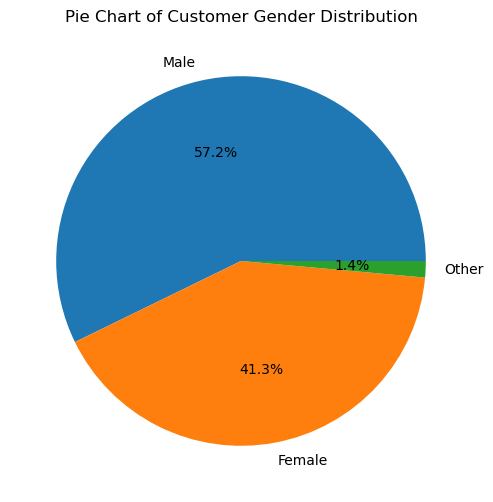

In [63]:
# profile.gender.value_counts(normalize = True).plot(kind = 'bar')
gender = ['Male', 'Female', 'Other']
gender_counts = profile.gender.value_counts().values

# Create a pie chart of the number of customers for each gender
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender, autopct="%1.1f%%")
plt.title("Pie Chart of Customer Gender Distribution")
plt.show()

Majority of the customer are male with value of more than 50% of them. 

Is there a pattern where woman are more prone to complete the offer compare to man? Let's find about that.

## Relationships between Customer's Feature and the Offers


We realized earlier that the majority of our customer are male but does it apply the same for those who completed the offer? Let's find out on that.

In [64]:
#create a customer table that holds information on their response towards the offer
cust = df.groupby('customer_id')[['transaction','offer_received','offer_viewed','offer_completed','amount']].sum()
#sort the table by the highest value of transaction
cust = cust.sort_values(by = ['transaction'], ascending = False)
#add gender info
cust['gender'] = df.groupby('customer_id')['gender'].max()

In [65]:
#average of offer completed by each gender
gender_completed = cust.groupby('gender').offer_completed.mean()


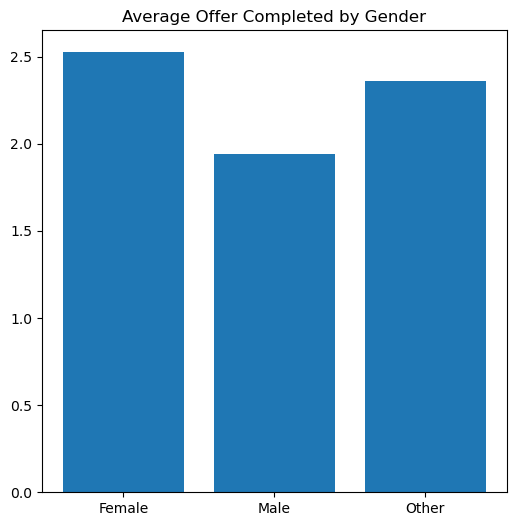

In [66]:
#setting up values for x and y axis
gender = ['Female', 'Male', 'Other']
y_val = gender_completed.values

# Create a bar chart of the number of customers for each gender
plt.figure(figsize=(6, 6))
plt.bar(gender, y_val)
plt.title("Average Offer Completed by Gender")
plt.show()

From the about result, we see that our male customer is in contrary contribute to least completed offer based on average per person. This is an interesting find where women and other gender tend to complete the offer most. 



Let's move on to the next question, how much transactions does the customer make and what's their spending pattern? 

In [67]:
# adding more columns to the new cust table
cust['transaction_no_offer'] = cust.transaction - cust.offer_completed
cust['income'] = df.groupby('customer_id')['income'].max()
cust['age'] = df.groupby('customer_id')['age'].max()


In [68]:
cust.head(10)

,transaction,offer_received,offer_viewed,offer_completed,amount,gender,transaction_no_offer,income,age
customer_id,,,,,,,,,
8936,36,5,3,4,173.41,M,32,34000.0,76
5554,36,5,5,3,76.46,M,33,48000.0,63
2699,35,6,5,5,90.23,M,30,33000.0,27
5821,32,6,5,5,103.66,M,27,55000.0,59
1277,32,5,5,4,133.02,M,28,64000.0,37
3418,31,6,4,5,461.09,F,26,33000.0,62
6713,30,4,4,4,220.22,M,26,31000.0,61
5214,30,6,6,6,260.69,M,24,37000.0,53
10117,30,6,6,1,83.04,M,29,36000.0,47


In [69]:
cust.tail()

,transaction,offer_received,offer_viewed,offer_completed,amount,gender,transaction_no_offer,income,age
customer_id,,,,,,,,,
8013,0,5,5,0,0.0,F,0,70000.0,52
968,0,4,4,0,0.0,F,0,88000.0,64
11498,0,4,2,0,0.0,M,0,52000.0,61
4076,0,4,4,0,0.0,M,0,77000.0,51
8934,0,4,4,0,0.0,M,0,85000.0,61


Since we cant track how much customer spend for each completed offer, what we can do here is to see the percentage of the offer transaction from the total transactions.

In [70]:
#find the % of offer to total transaction.
cust['perc_complete'] = round(cust.offer_completed/cust.transaction,2)


In [71]:
cust.head()

,transaction,offer_received,offer_viewed,offer_completed,amount,gender,transaction_no_offer,income,age,perc_complete
customer_id,,,,,,,,,,
8936,36,5,3,4,173.41,M,32,34000.0,76,0.11
5554,36,5,5,3,76.46,M,33,48000.0,63,0.08
2699,35,6,5,5,90.23,M,30,33000.0,27,0.14
5821,32,6,5,5,103.66,M,27,55000.0,59,0.16
1277,32,5,5,4,133.02,M,28,64000.0,37,0.12


In [72]:
#encode the column 'gender' in the string format to integer
gender_dict = {'O': 0, 'M': 1, 'F': 2}
cust['gender'] = cust['gender'].map(gender_dict)

Now let's look at how much each attribute correlate with the completed offer.

In [73]:
corr_matrix = cust.corr()
corr_matrix['offer_completed'].sort_values(ascending = False)

offer_completed         1.000000
perc_complete           0.539021
amount                  0.537203
transaction             0.417381
offer_viewed            0.398986
offer_received          0.333998
income                  0.257836
gender                  0.166791
transaction_no_offer    0.122426
age                     0.114036
Name: offer_completed, dtype: float64

The most positive correlated attribute is the perc_complete which is the amount of completed offer over the total transaction. It follows by the total amount spent by the customer. So the customer who spend more are more likely to complete the offer.

So correlation number above shows the strength of the linear relationship between the completed offers and all other numerical variables. Now let have a look at them when they are plotted in graphs.

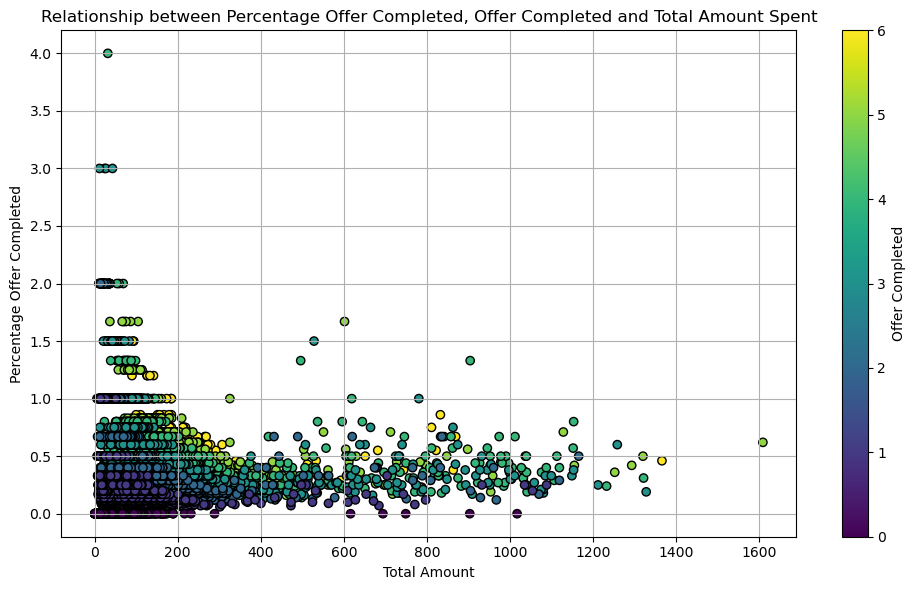

In [104]:
import matplotlib.pyplot as plt
import numpy as np

perc_completed = cust.perc_complete
offer_com = cust.offer_completed
total_spend = cust.amount

# Scatter plot with color coding based on promo usage
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(total_spend, perc_completed, c=offer_com, cmap='viridis', edgecolors='black')

# Label axes and title
plt.xlabel('Total Amount')
plt.ylabel('Percentage Offer Completed')
plt.title('Relationship between Percentage Offer Completed, Offer Completed and Total Amount Spent')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(offer_com), max(offer_com)))
sm.set_array([])
plt.colorbar(sm, ax= ax, label='Offer Completed')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

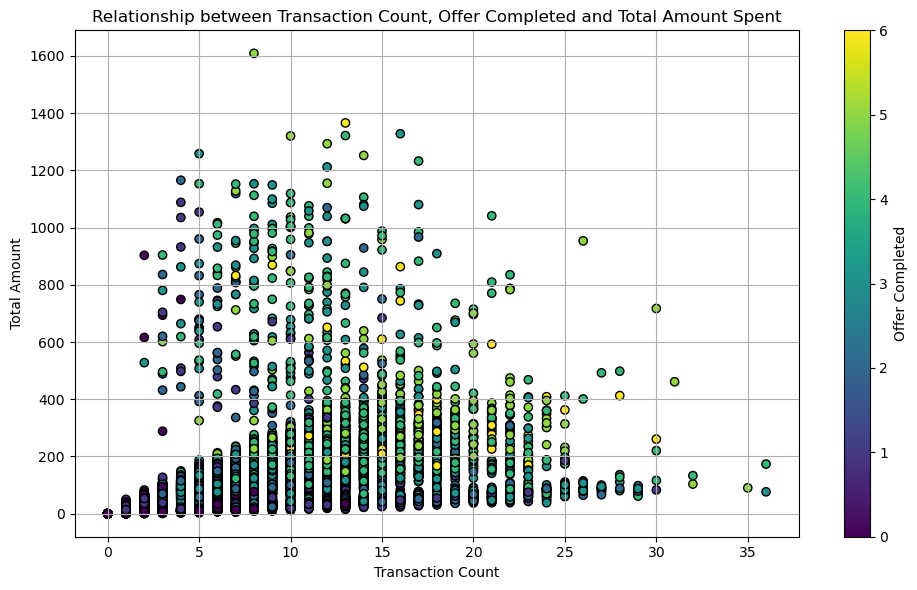

In [105]:

transaction_counts = cust.transaction
offer_com = cust.offer_completed
total_spend = cust.amount


# Scatter plot with color coding based on promo usage
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(transaction_counts, total_spend, c=offer_com, cmap='viridis', edgecolors='black')

# Label axes and title
plt.xlabel('Transaction Count')
plt.ylabel('Total Amount')
plt.title('Relationship between Transaction Count, Offer Completed and Total Amount Spent')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(offer_com), max(offer_com)))
sm.set_array([])
plt.colorbar(sm,ax = ax, label='Offer Completed')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

There is no direct correlation that we can see here. The higher transaction count doesn't mean the spending amount is also higher. The higher promo usage is in the middle area of the distribution. But what we can see is that the higher offer completion lies more in the the middle range of the transaction count.

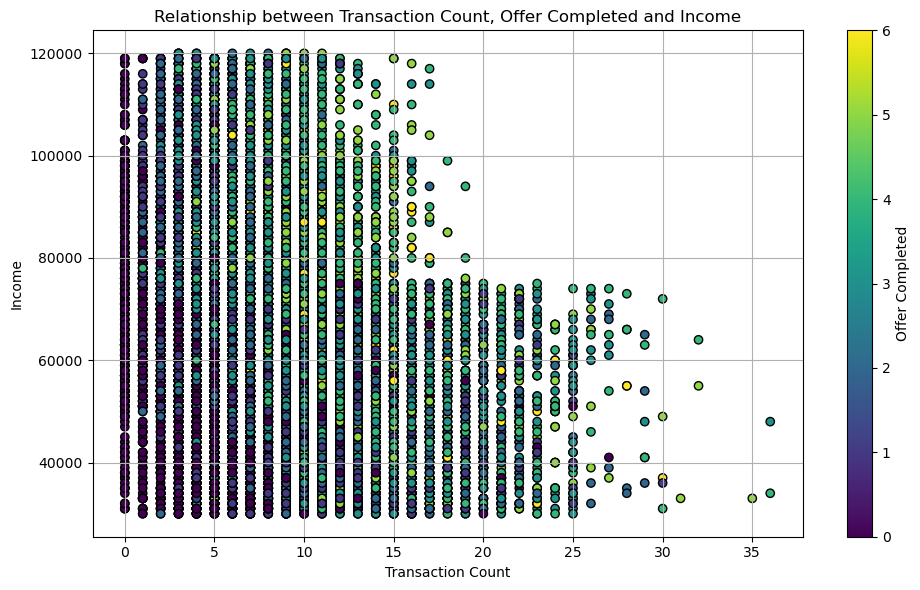

In [110]:

transaction_counts = cust.transaction
promo_usage = cust.offer_completed
income = cust.income

# Scatter plot with color coding based on promo usage
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(transaction_counts, income, c=promo_usage, cmap='viridis', edgecolors='black')

# Label axes and title
plt.xlabel('Transaction Count')
plt.ylabel('Income')
plt.title('Relationship between Transaction Count, Offer Completed and Income')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(promo_usage), max(promo_usage)))
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Offer Completed')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

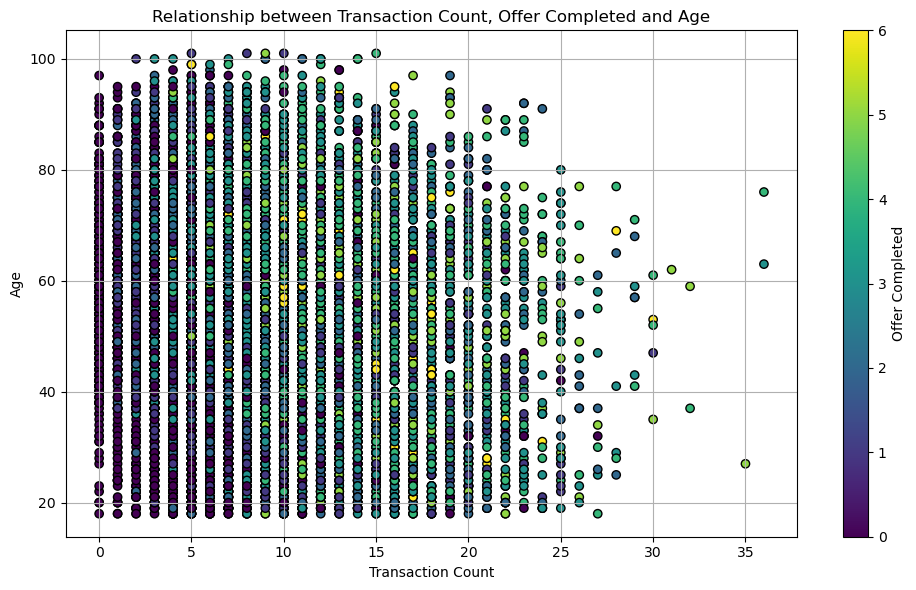

In [112]:

transaction_counts = cust.transaction
promo_usage = cust.offer_completed
age = cust.age

# Scatter plot with color coding based on promo usage
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(transaction_counts, age, c=promo_usage, cmap='viridis', edgecolors='black')

# Label axes and title
plt.xlabel('Transaction Count')
plt.ylabel('Age')
plt.title('Relationship between Transaction Count, Offer Completed and Age')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(min(promo_usage), max(promo_usage)))
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Offer Completed')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
#Calculate Percentiles:

#calculate the 25th, 50th, and 75th percentiles for both income and transaction_counts:

income_25th = income.quantile(.25)
income_50th = income.quantile(.5)
income_75th = income.quantile(.75)

transaction_25th = np.percentile(transaction_counts, 25)
transaction_50th = np.percentile(transaction_counts, 50)
transaction_75th = np.percentile(transaction_counts, 75)
transaction_100th = np.percentile(transaction_counts, 100)



# Building Machine Learning Model
Build a Machine Learning model to predict response of a customer to an offer and to find important features that help drive the offers in customers.

## Data Preparation

Before we strat training our model, we need to clean our dataset first. Some on the steps to be taken are as below:
- impute or remove missing value?
- making sure all are numerical attributes and drop all non numerical
- rescale using MinMaxScaler on attributes so they range from 0 to 1
- separate the target and features columns

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272762 entries, 0 to 272761
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gender            272762 non-null  object        
 1   age               272762 non-null  int64         
 2   customer_id       272762 non-null  int64         
 3   became_member_on  272762 non-null  datetime64[ns]
 4   income            272762 non-null  float64       
 5   time              272762 non-null  int64         
 6   offer_completed   272762 non-null  int64         
 7   offer_received    272762 non-null  int64         
 8   offer_viewed      272762 non-null  int64         
 9   transaction       272762 non-null  int64         
 10  amount            123957 non-null  float64       
 11  offer_id          148805 non-null  float64       
 12  reward            148805 non-null  float64       
 13  difficulty        148805 non-null  float64       
 14  dura

Base on the information above, we have almost have of the information missing. The model we want to train later is to see which customer is more prone to complete the offer base on which offer. Hence, if we have missing information on either of the customer or offer, we are to going to remove those rows. 

In [82]:
df = df[df.offer_id.notna()]

In [83]:
# df['gender'] = df.gender.replace(['M','F','O'],[1,2,3])
#process categorical variables
categorical = ['gender']
df = pd.get_dummies(df, columns = categorical,dtype =int)

In [84]:
df = df.drop(labels=['became_member_on','amount','offer_type','customer_id','offer_id','offer_received','offer_viewed'], axis=1)
df.columns

Index(['age', 'income', 'time', 'offer_completed', 'transaction', 'reward',
       'difficulty', 'duration', 'bogo', 'discount', 'informational', 'email',
       'mobile', 'social', 'web', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [85]:
df.iloc[3]

age                   61.0
income             57000.0
time                 408.0
offer_completed        0.0
transaction            0.0
reward                10.0
difficulty            10.0
duration               7.0
bogo                   1.0
discount               0.0
informational          0.0
email                  1.0
mobile                 1.0
social                 1.0
web                    0.0
gender_F               1.0
gender_M               0.0
gender_O               0.0
Name: 3, dtype: float64

In [86]:
#process numerical variables
#initialize a MinMaxScaler, then apply it to the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age','income','time', 'reward','difficulty', 'duration']
df[numerical] = scaler.fit_transform(df[numerical])

In [87]:
target = df.offer_completed
features = df.drop('offer_completed', axis = 1)
print(" Number of total features: {} ".format(len(features.columns)))

 Number of total features: 17 


## Split Train and Test dataset

Now that we have normalize the numerical values, we can move to the next step which is splitting the data into train and test dataset.

In [88]:
X_train, X_test, y_train, y_test = train_test_split(features, target,test_size = 0.4, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89283, 17), (59522, 17), (89283,), (59522,))

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148805 entries, 0 to 148804
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age              148805 non-null  float64
 1   income           148805 non-null  float64
 2   time             148805 non-null  float64
 3   offer_completed  148805 non-null  int64  
 4   transaction      148805 non-null  int64  
 5   reward           148805 non-null  float64
 6   difficulty       148805 non-null  float64
 7   duration         148805 non-null  float64
 8   bogo             148805 non-null  float64
 9   discount         148805 non-null  float64
 10  informational    148805 non-null  float64
 11  email            148805 non-null  float64
 12  mobile           148805 non-null  float64
 13  social           148805 non-null  float64
 14  web              148805 non-null  float64
 15  gender_F         148805 non-null  int64  
 16  gender_M         148805 non-null  int64  
 

Since the offers_completed in the dataset is really imbalanced and is very underrepresented, we will be using the F1-score as our metric. F1-score is the combination of precision and recall in single unit.

## Modelling Data

### Decision Tree Classifier

In [90]:
start = time()
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
dtc_pred = dtc_model.predict(X_test)
end = time()
dtc_total_time = end - start
accuracy_dtc = accuracy_score(y_test, dtc_pred)

print("Classification Report: \n", classification_report(y_test, dtc_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.86      0.86     46563
           1       0.48      0.47      0.48     12959

    accuracy                           0.77     59522
   macro avg       0.67      0.66      0.67     59522
weighted avg       0.77      0.77      0.77     59522



### Random Forest Classifier

In [91]:
start = time()
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
rfc_pred = rfc_model.predict(X_test)
end = time()
rfc_total_time = end - start
accuracy_rfc = accuracy_score(y_test, rfc_pred)

print("Classification Report: \n", classification_report(y_test, rfc_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.85     46563
           1       0.42      0.28      0.33     12959

    accuracy                           0.76     59522
   macro avg       0.62      0.59      0.59     59522
weighted avg       0.73      0.76      0.74     59522



### Ada Boost Classifier

In [92]:
start = time() 
abc_model = AdaBoostClassifier()
abc_model.fit(X_train, y_train)
abc_pred = abc_model.predict(X_test)
end = time() 
abc_total_time = end-start
accuracy_abc = accuracy_score(y_test, abc_pred)

print('Classification Report: \n', classification_report(y_test, abc_pred))

/opt/homebrew/Caskroom/miniconda/base/envs/starbuckproject/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.96      0.88     46563
           1       0.62      0.21      0.31     12959

    accuracy                           0.80     59522
   macro avg       0.72      0.59      0.60     59522
weighted avg       0.77      0.80      0.76     59522



### K-Neighbors Classifier

In [93]:
start = time() 
knc_model = KNeighborsClassifier(n_neighbors=5)
knc_model.fit(X_train, y_train)
knc_pred = knc_model.predict(X_test)
end = time() 
knc_total_time = end-start
accuracy_knc = accuracy_score(y_test, knc_pred)

print('Classification Report: \n', classification_report(y_test, knc_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     46563
           1       0.49      0.22      0.30     12959

    accuracy                           0.78     59522
   macro avg       0.65      0.58      0.59     59522
weighted avg       0.74      0.78      0.75     59522



### Gradient Boosting Classifier

In [94]:

start = time() 
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_test)
end = time() 
gbc_total_time = end-start
accuracy_gbc = accuracy_score(y_test, gbc_pred)

print('Classification Report: \n', classification_report(y_test, gbc_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89     46563
           1       0.64      0.51      0.57     12959

    accuracy                           0.83     59522
   macro avg       0.76      0.71      0.73     59522
weighted avg       0.82      0.83      0.82     59522



## Model Decision

Let's compare all F1-Score and fined the best result among all.

In [95]:
# Defining the data

data = {
    'Model' : ["Decision Tree", "Random Forest","Ada Boost", "K-Neighbors", "Gradient Boosting"],
    'F1-Score' : [f1_score(y_test, dtc_pred), f1_score(y_test, rfc_pred), f1_score(y_test, abc_pred), f1_score(y_test, knc_pred), f1_score(y_test, gbc_pred)],
    'Accuracy' : [accuracy_dtc * 100.0, accuracy_rfc * 100.0, accuracy_abc * 100.0, accuracy_knc * 100.0, accuracy_gbc * 100.0],
    'Training Duration' : [dtc_total_time, rfc_total_time, abc_total_time, knc_total_time, gbc_total_time]
}

# Creating a DataFrame
df_ModelScore = pd.DataFrame(data)

# Formatting the Accuracy column to show percentages
df_ModelScore['Accuracy'] = df_ModelScore['Accuracy'].apply(lambda x: "%.2f%%" % x)

# Sorting by F1-Score in descending order
df_ms_sorted = df_ModelScore.sort_values(by='F1-Score', ascending=False, ignore_index = True)

print(df_ms_sorted)


               Model  F1-Score Accuracy  Training Duration
0  Gradient Boosting  0.565708   83.06%           4.922707
1      Decision Tree  0.475362   77.30%           0.256948
2      Random Forest  0.333411   76.02%           5.881752
3          Ada Boost  0.310819   79.94%           1.380754
4        K-Neighbors  0.300188   78.09%           2.742051


The model that scored the highest is Gradient Boosting Classifier with a score of 0.566 and the highest accuracy as well with 83%. While Gradient Boosting can be slower to train compared to some algorithms, it can handle large datasets efficiently and effectively.

In [96]:
#plotting the n-number of features in a bar chart

def feature_plot(importances, X_train, y_train, n=5):
    # Display the five most important features by default
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n]]
    values = importances[indices][:n]

    # Creat the plot
    fig = plt.figure(figsize = (8,5))
    plt.title(f"Normalized Weights for First {n} Predictive Features")#, fontsize = 16)
    plt.bar(np.arange(n), values, width = 0.2, align="edge", color = ('#E26741',0.7), \
          label = "Feature Weight")
    plt.bar(np.arange(n) - 0.2, np.cumsum(values), width = 0.2, align = "edge", color = ('#8E1FEF',0.7), \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n), columns)
    #pl.xlim((-0.5, 4.5))
    plt.ylabel("Weight")
    plt.xlabel("Feature")#
    
    plt.legend(loc = 'upper left')
    plt.show()

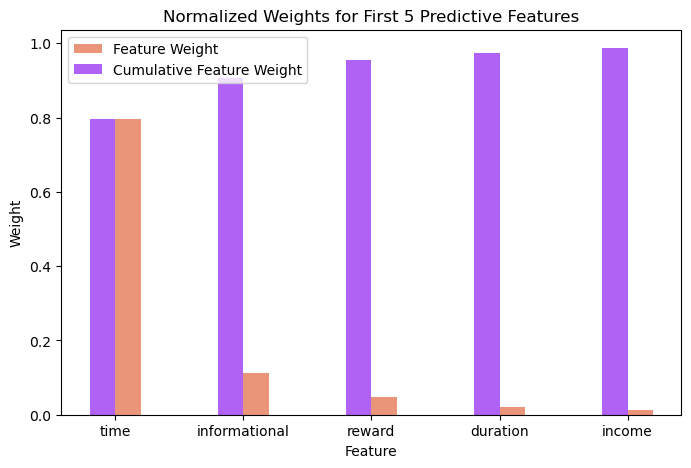

In [97]:
#  Extract the feature importances using .feature_importances_ 
importances = gbc.feature_importances_

# Plot
feature_plot(importances, X_train, y_train)

The top five features that that are predicted by our supervised learning model whether a customer would complete the offer or not are plotted in the graph above with the highest weighted feature as time followed by informational,reward,duration and income.

# Conclusion

__Challenges__

There were a few challenges that were faced in this project. Initially we discovered that the data were inconsistent for example for the age. Some of the customer's have very high value in age(118 years old) which could be some default value passed in the system when customer didn't entered their age when registering. This customers also have missing values for other main attributes. So, instead of taking this data in which would cause a bias result, we removed them. The percentage of them were about 13% from the total unique customers that we have. Removing this has reduced our dataset size which reduced our training sets too. 

Other inconsistency in data we found is in th eportfolio dataframe where there are *offer_id* and *offer id* in the same *value* column. So these are the small things that we need to clean up prior to analysing the dataset which if not, it may impact our analysis.

Besides, whenever a customer made a transaction, the transaction could not be link to whether the customer using the voucher or not. Let say if you can get this information, we can trace to the offer and find out which offer bring the higher revenue to the company. 

__Ideas for Improvements__

* There are many other attributes to explore in the EDA part. For example solving queries related to the channels(either web, mobile or social media) used in distributing offers, duration and membership.

* We could also try different modelling algorithms and applying some hyperparameter tuning to get better prediction model and on the same time making sure we are not overfitting our model. 


In [98]:

   So the top three attributes that we can use to define our top customers are base on how many time they completed the offer, follow by perc_complete and the total amount they spent. So next time we can send out offers on targeted customers. 
   
**Ideas**:
- high value cust, sent out offer to increase their spending
- sent special offer trying to convert customer (high spending customers wont bother much with voucher or coupon or offer, but we can target on customer base on 0-50th percentile that has offer completion <1/2 including those haven't convert
- should we classify all these group of customers?

SyntaxError: invalid decimal literal (2302310063.py, line 5)